In [1]:
import geopandas as gpd
import pandas as pd
from gerrychain import Graph
import random
import networkx as nx
import numpy as np

import facefinder
import numpy as np
import pandas as pd
import random
import pickle
import csv
import copy
import statistics
import math
import gerrychain
import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import os
import json
import argparse
from functools import partial
from gerrychain.tree import bipartition_tree as bpt
from gerrychain import Graph, MarkovChain
from gerrychain import accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
                                    within_percent_of_ideal_population, UpperBound)
from gerrychain.proposals import propose_random_flip, propose_chunk_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain import GeographicPartition
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap
from gerrychain.tree import recursive_tree_part, bipartition_tree_random, PopulatedGraph, random_spanning_tree
from collections import defaultdict
from datetime import datetime
import time
from concurrent.futures import ProcessPoolExecutor
import logging


# Helper functions

In [2]:
def agglomerate(graph, agg_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, 
                steps = 1000000):
    # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
    # also allow merging of zero pop blocks with no condition.
    for i in range(steps):
        #if i % 100000 == 0:
            #print(i)
        if i % 10000 == 0:
            edges = list(graph.edges())
        e = random.choice(edges)
        if graph.has_edge(e[0], e[1]):

            if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
                 graph.nodes[e[1]]['TOTPOP_block'] == 0 or
                 (graph.nodes[e[0]][agg_field] >  agg_field_threshold and 
                graph.nodes[e[1]][agg_field] >  agg_field_threshold)):
                tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
                tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
                tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
                #print(tot_pop)
                if tot_pop < pop_cap:
                    graph.nodes[e[0]]['cluster'] = graph.nodes[e[0]]['cluster'] + graph.nodes[e[1]]['cluster'] 
                    nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
                    # according to documentation node named e[0] remains
                    #print(e)
                    graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
                    graph.nodes[e[0]]['dem'] = tot_dem
                    graph.nodes[e[0]]['rep'] = tot_rep
                    if tot_pop !=0 :

                        graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
                        graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
                    else:
                        graph.nodes[e[0]]['dem_prop'] = np.nan
                        graph.nodes[e[0]]['rep_prop'] = np.nan

In [9]:
def create_candidate(blocks_graph,
                     target_num_vtds = 4000,
                    dem_threshold = .7, dem_pop_cap = 8000, dem_steps = 200000,
                    rep_threshold = 0, rep_pop_cap = 2000, rep_steps = 2000,
                     final_push_vtd_target_size = 1000,
                     save = False,
                     print_progress = False
                    ):
    blocks_graph_test = blocks_graph_in.copy()
    if print_progress:
        print(f"Currently has {len(blocks_graph_test)} nodes")
    last = len(blocks_graph_test)
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]['cluster'] = [n]
    while len(blocks_graph_test) > target_num_vtds:
        agglomerate(graph = blocks_graph_test, agg_field = "dem_prop", 
                    agg_field_threshold = dem_threshold,  pop_cap = dem_pop_cap,  steps = dem_steps)
        agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = rep_threshold,  pop_cap = rep_pop_cap,  steps = rep_steps)
        if print_progress:
            print(f"Currently has {len(blocks_graph_test)} nodes")
        if len(blocks_graph_test) == last:
            # some more aggressive joining at this point
            agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = 0,  pop_cap = final_push_vtd_target_size,  steps = 2000000)
        last = len(blocks_graph_test)
    if print_progress:
        print("Finished. Stats:")    
        print(f"Has {len(blocks_graph_test)} VTDs")
        pops = []
        for node in blocks_graph_test.nodes():
            if blocks_graph_test.nodes[node]['dem'] > blocks_graph_test.nodes[node]['rep'] * 0:
                pops.append(blocks_graph_test.nodes[node]['TOTPOP_block'])
        pd.Series(pops).plot(kind = 'hist', bins = 30, title = "VTD pops")
        plt.show()
    name = str(datetime.now()).replace(" ", "").replace(":", "_")
    saved_name = f"candidate_blocks_graph{name}"
    if save == True:

        nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')
    return blocks_graph_test, saved_name

In [26]:
def gerry(blocks_graph_test, gerrychain_steps = 10000, epsilon = .2, plot = False):
    updaters = {'population': Tally('population'),
                        'cut_edges': cut_edges,
                        }
    num_districts = 13
    ideal_population= sum( blocks_graph_test.nodes[x]["TOTPOP_block"] for x in blocks_graph_test.nodes())/ num_districts

    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["population"] =  blocks_graph_test.nodes[n]["TOTPOP_block"]
    
        
    # accept imported
    initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                            range(num_districts), 
                                                            ideal_population, "population", epsilon)
    
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]
    
    initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)
    
    
    popbound = within_percent_of_ideal_population(initial_partition, epsilon)
    tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
                                node_repeats=1)


    exp_chain = MarkovChain(tree_proposal, Validator([popbound]), accept=accept.always_accept,
                            initial_state=initial_partition, total_steps=gerrychain_steps)
    seats_won_for_republicans = []
    seats_won_for_democrats = []
    
    for part in exp_chain:
        rep_seats_won = 0
        dem_seats_won = 0
        for j in range(num_districts):
            rep_votes = 0
            dem_votes = 0
            for n in blocks_graph_test.nodes():
                if part.assignment[n] == j:
                    rep_votes += blocks_graph_test.nodes[n]["rep"]
                    dem_votes += blocks_graph_test.nodes[n]["dem"]
            total_seats_dem = int(dem_votes > rep_votes)
            total_seats_rep = int(rep_votes > dem_votes)
            rep_seats_won += total_seats_rep
            dem_seats_won += total_seats_dem
        seats_won_for_republicans.append(rep_seats_won)
        seats_won_for_democrats.append(dem_seats_won)

    rep_avg = statistics.mean(seats_won_for_republicans)
    dem_avg = statistics.mean(seats_won_for_democrats)
    
    if plot:
        print("avg rep seats ", rep_avg)
        print("avg dem seats ", dem_avg)

        pd.Series(seats_won_for_republicans).plot(kind = 'hist', title = 'rep seats')
        plt.show()
        plt.close()
    return dem_avg, rep_avg, seats_won_for_republicans

# Load

In [6]:
blocks_graph_in = Graph.from_json('./processed_data_outputs/blocks_graph.json')

# Experiments

In [ ]:

# print('running gerrychain')
# while True:
#     try:
#         dem_avg, rep_avg = gerry(contracted, gerrychain_steps = 2000)
#         break
#     except:
#         print('error, retrying')
#         time.sleep(1) # to let you escape more easily
# if rep_avg > 9:
#     print(f"success(?) with {saved_name} as {dem_avg}, {rep_avg}")
#     print("writing to file")
#     nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')

## Finding VTD partitions using recursive tree splits...

In [7]:
def condensce_by_partition(graph, part):
    # given graph, and label field for each node, return graph where all the nodes with the same lable have been contracted
    # also, add up the pops and votes in each block
    graph_copy = graph.copy()
    
    for supernode in part.parts.values():
        nodes = list(supernode)
        for node in nodes[1:]:
            
            tot_pop = graph_copy.nodes[nodes[0]]['TOTPOP_block'] + graph_copy.nodes[node]['TOTPOP_block']
            tot_dem = graph_copy.nodes[nodes[0]]['dem']+ graph_copy.nodes[node]['dem']
            tot_rep = graph_copy.nodes[nodes[0]]['rep'] + graph_copy.nodes[node]['rep']
            nx.contracted_nodes(graph_copy, nodes[0], node, copy = False)
            graph_copy.nodes[nodes[0]]['TOTPOP_block'] = tot_pop
            graph_copy.nodes[nodes[0]]['dem'] = tot_dem
            graph_copy.nodes[nodes[0]]['rep'] = tot_rep
            
    return graph_copy

Currently has 288987 nodes
Currently has 226199 nodes
Currently has 190325 nodes
Currently has 165707 nodes
Currently has 145357 nodes
Currently has 126938 nodes
Currently has 109886 nodes
Currently has 93987 nodes
Currently has 79437 nodes
Currently has 66551 nodes
Currently has 55691 nodes
Currently has 46687 nodes
Currently has 39551 nodes
Currently has 34232 nodes
Currently has 30342 nodes
Currently has 27593 nodes
Finished. Stats:
Has 27593 VTDs


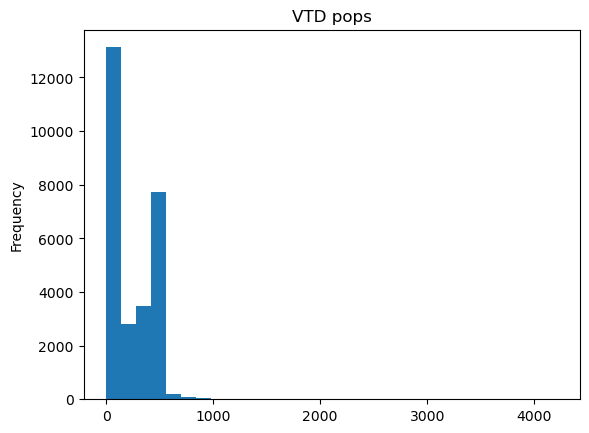

In [11]:
blocks_graph_test, saved_name = create_candidate(blocks_graph_in,               
                    target_num_vtds = 30000,
                    dem_threshold = .7, dem_pop_cap = 500, dem_steps = 200000,
                    rep_threshold = 0, rep_pop_cap = 500, rep_steps = 20000,
                                                 final_push_vtd_target_size = 500,
                                                 save = False, print_progress = True)

In [12]:
blocks_graph_test_back = blocks_graph_test.copy()
# okay with shallow copy

In [27]:
name = str(datetime.now()).replace(" ", "").replace(":", "_")
nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/agglomerated_graph{name}.json')

In [55]:
num_vtds = 1500
for n in blocks_graph_test.nodes():
    blocks_graph_test.nodes[n]["population"] =  1
    #blocks_graph_test.nodes[n]["population"] = round( blocks_graph_test.nodes[n]["TOTPOP_block"],0)



ideal_population= sum( blocks_graph_test.nodes[x]["population"] for x in blocks_graph_test.nodes())/ num_vtds

initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                            
                                                            range(num_vtds), ideal_population,
                                                                  "population", epsilon = .8)


for n in blocks_graph_test.nodes():
    blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]

    
initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)



In [56]:
ideal_population

18.395333333333333

In [57]:
epsilon = .8
gerrychain_steps = 50000
steps_in_between = 1000
test_step_steps = 2000
validate_steps = 20000
updaters = {'population': Tally('population'),
                    'cut_edges': cut_edges,
                    }


The reason why the below is crashing is because gerrychain can't handle the cast of two blocks of a single noe each being merged.

starting chain
200
400
600
800
1000
contracting
running test gerry
avg rep seats  7.2675
avg dem seats  5.7325


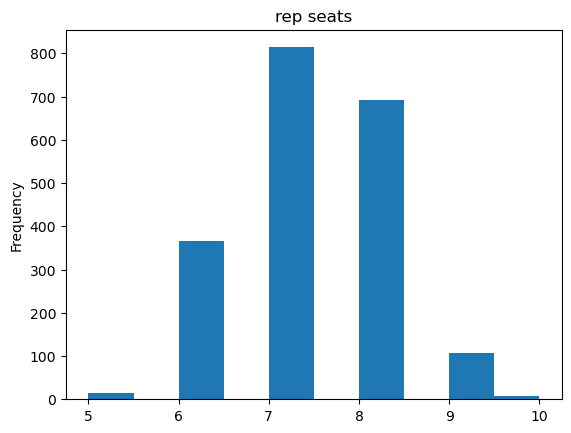

Test  step found, 5.7325 , 7.2675
1200
1400
1600
1800
2000
contracting
running test gerry
avg rep seats  7.47
avg dem seats  5.53


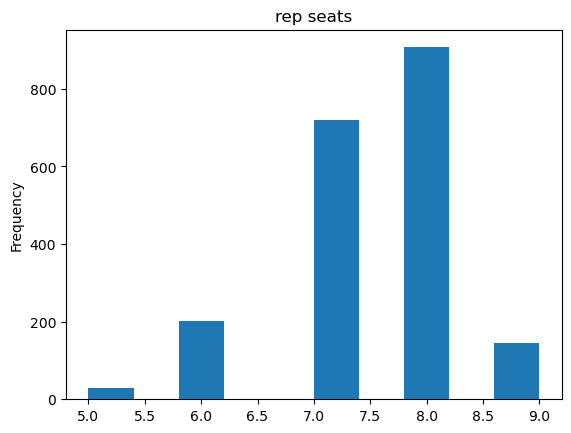

Test  step found, 5.53 , 7.47
restarting from last good partition
2200
2400
2600
2800
3000
contracting
running test gerry
avg rep seats  7.14
avg dem seats  5.86


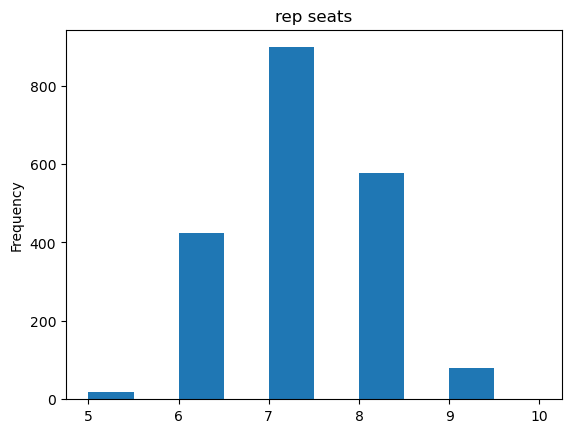

Test  step found, 5.86 , 7.14
3200
3400
3600
3800
4000
contracting
running test gerry
avg rep seats  7.235
avg dem seats  5.765


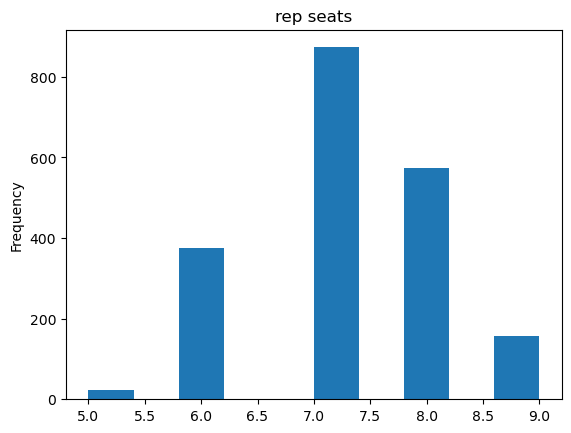

Test  step found, 5.765 , 7.235
4200


In [ ]:
epsilon = .8
gerrychain_steps = 50000
steps_in_between = 1000
test_step_steps = 2000
validate_steps = 20000

current_part = initial_partition
seats_won_for_republicans = []
seats_won_for_democrats = []
i = 0

# for i in range(1000):


initial_partition = current_part
popbound = within_percent_of_ideal_population(initial_partition, epsilon)
tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
                            node_repeats=1)


exp_chain = MarkovChain(tree_proposal, Validator([]), accept=accept.always_accept,
                        initial_state=initial_partition, total_steps=gerrychain_steps)

found_graphs = []
print('starting chain')
while i < gerrychain_steps:
    try:
        for part in exp_chain:
            i += 1
            if i % int(steps_in_between / 5) == 0:
                print(i)
            if i % steps_in_between == 0:
                print('contracting')
                contracted = condensce_by_partition(blocks_graph_test, part)
                #print(contracted)
                while True:
                    try:
                        print("running test gerry")
                        dem_avg, rep_avg, seats_won_for_republicans = gerry(contracted, 
                                                                            gerrychain_steps = test_step_steps,
                                                                            plot = True)
                        break
                    except:
                        print('error, retrying')
                        time.sleep(1) # to let you escape more easily
                print(f"Test  step found, {dem_avg} , {rep_avg}")
                if rep_avg > 8 or rep_avg < 7:
                    while True:
                        try:
                            print("running validate gerry")
                            dem_avg, rep_avg, seats_won_for_republicans = gerry(contracted, 
                                                                                gerrychain_steps = validate_steps,
                                                                               plot = True)
                            break
                        except:
                            print('error, retrying')
                            time.sleep(1) # to let you escape more easily
                    print(f"Validate  step found, {dem_avg} , {rep_avg}")
                    if rep_avg >= 8 or rep_avg <= 7:
                        found_graphs.append(contracted)
                        name = str(datetime.now()).replace(" ", "").replace(":", "_")
                        pd.Series(seats_won_for_republicans).plot(kind = 'hist', title = 'rep seats')
                        plt.savefig(f'./metamandered_NC/histogram{name}.png')
                        plt.close()
            current_part = part
    except:
        time.sleep(1)
        print("restarting from last good partition")


In [44]:
dem_avg, rep_avg, seats_won_for_republicans = gerry(contracted, 
                                                    gerrychain_steps = validate_steps,
                                                   plot = False)

In [40]:
dem_avg, rep_avg, seats_won_for_republicans = gerry(contracted, 
                                                    gerrychain_steps = test_step_steps,
                                                    plot = False)

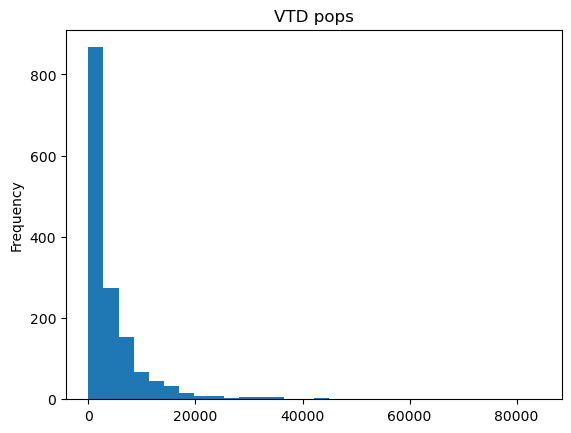

In [44]:
pops = []
for node in contracted.nodes():
    if contracted.nodes[node]['dem'] > contracted.nodes[node]['rep'] * 0:
        pops.append(contracted.nodes[node]['TOTPOP_block'])
pd.Series(pops).plot(kind = 'hist', bins = 30, title = "VTD pops")
plt.show()

## Do a random walk over VTD partitions with gerrychain...